In [1]:
%load_ext autoreload
%autoreload 2

import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend(['C:\\Users\\troy\\Documents\\Code\\Libraries', 'C:\\Users\\troy\\Documents\\Excel Sheets', 'C:/Users/troy/Documents/Code/Libraries'])
from datetime import date, datetime
import numpy as np
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt
import autoreload

import dash_bootstrap_components as dbc
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
import dash_table
from dash.dependencies import Input, Output

from FinAPI.PortfolioAnalysis.AnalyzePortfolio import Portfolio

today = date(2021, 10, 28)
objPortfolio = Portfolio(today)

Python 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)] on win32


## Create Pivot for Positions

In [14]:
import pandas as pd

trader = "troy"
asset_type = "ALL"
asset_class = "ALL"
theme_name = "ALL"
only_open = False
only_option = False
remove_matured = True

df= objPortfolio.create_position_pivot_with_filters(trader, asset_type, asset_class, theme_name, only_open, only_option, remove_matured)

## New Trades

In [3]:
trader_df =objPortfolio.get_trades_by_trader(objPortfolio.raw_data, 'troy')
df_New = objPortfolio.filter_new_trades(trader_df)

## ED Ladder

In [22]:
trade_names = ["ED Bearish Bfly H3-U3-H4 TRRMRR", "ED Bullish BFly Z1-M2-Z2", "EDH3H5 vs. EDh3EDH4 RV TRRMRR", "EDH6EDM6 Steepener TRRM", "EDU2EDZ2 vs. EDU3EDZ3 RV TRRMRR",
"EDU3EDZ3 Steepener TRRM", "EDU3EDZ3 Steepener TRRMRR"]

trader_df =objPortfolio.get_trades_by_trader(objPortfolio.raw_data, 'troy')
filtered_trades = trader_df[trader_df['Trade Name'].isin(trade_names)]

# Aggregate exposure
total_exposure = filtered_trades.groupby(by="Security Id").agg(NumberOfContractsSum=('Number Of Contracts', 'sum')).reset_index()

# Security wise trade composition
ed_exposure_tradewise = 


# <span style="color:red"> Equity Trades </span>

## List all Equity Trades

In [39]:
trader_df =objPortfolio.get_trades_by_trader(objPortfolio.raw_data, 'troy')
trader_df[trader_df['Asset Class']=='Equity']['Trade Name'].unique()

array(['ESV1 EOM 4550 Call TRRMRR', 'ESU1 EOM Put Spread',
       'VIX OCT 25/ 30 / 35 Call BFLY TRRMRR', 'ESU1 4450 Call TRRMRR',
       'VIX Sep Call Spread 23/30 TRRMRR', 'VIX Call Spread 20 / 28 TRRR',
       'SPX Jul Call 4370 TRRMRR', 'ESM1 3950/3850 PS TRRMRR',
       'ES 28May21 4050 / 4150 CS TRRMRR', 'ES 28May21 4000/4100 CS TRRM',
       'VIX FEB 20-18 PS TRRMRR', 'SPX CALL 4000 TRRM',
       'VIX Dec20 19 Put TRRRRM', 'SPX Mar 3700 Call TRRMRR'],
      dtype=object)

## Individual Trade Setup

In [41]:
from FinAPI.PortfolioAnalysis.AnalyzePortfolio import EquityFutureOptionTrade
from tia.bbg import LocalTerminal
pd.options.mode.chained_assignment = None

# Load EquityFutureOption for a Live trade
trade_name = 'ESV1 EOM 4550 Call TRRMRR'
trader_df =objPortfolio.get_trades_by_trader(objPortfolio.raw_data, 'troy')
working_df = trader_df[trader_df['Trade Name']==trade_name]

## Trade Aggregation

In [56]:
working_df['Number Of Contracts'] = (1 - working_df['Is Matured']) * working_df['Number Of Contracts']
option_prem = working_df.groupby(by='Security Id')\
                        .agg(tot_upfront=('Upfront', 'sum'), total_exposure=('Number Of Contracts', 'sum'))\
                        .reset_index()

# 1. Detailed upfront report ---> report with the total premium spent per option in the trade and the current total exposure
option_prem_w_subtotal = option_prem.sort_values(by='total_exposure').append({'tot_upfront': option_prem['tot_upfront'].sum(), 
                                                                                'total_exposure': option_prem['total_exposure'].sum(), 
                                                                                'Security Id': 'TOTAL'}, ignore_index=True)

# 2. Option Aggregate Collapsed ---> 
#       1. Collapse the trades with 0 exposure into one category which represents the total PNL from these trades.
#       2. Compute the --- active securities ---- for the trade (trades which have non zero current exposure)
option_prem_collapsed =  option_prem.groupby(by='total_exposure').agg('sum').merge(option_prem, 'left')
active_securities = np.array(option_prem_collapsed['Security Id'].dropna())
option_prem_collapsed['Security Id'] = option_prem_collapsed['Security Id'].fillna('Closed Securities')
option_prem_collapsed['total_exposure'] = option_prem_collapsed['total_exposure'].fillna(0)
option_prem_collapsed = option_prem_collapsed[option_prem.columns]
# option_prem_collapsed = option_prem_collapsed.append({'tot_upfront': option_prem['tot_upfront'].sum(), 
#                                                       'total_exposure': option_prem['total_exposure'].sum(), 
#                                                       'Security Id': 'TOTAL'}, ignore_index=True)

# 3. Trade Blotter, Entry, Exit ---> Datewise report of entry and exit from the options
working_df = trader_df[trader_df['Trade Name']==trade_name]
working_df = working_df.assign(total_prem=working_df['Number Of Contracts'] * working_df['Upfront'])
blotter = working_df.groupby(by=["Trade Date", "Security Id"]).agg(tot_upfront=('Upfront', 'sum'), total_contracts=('Number Of Contracts', 'sum')).reset_index()
blotter.insert(3, "Cummulative Upfront", blotter['tot_upfront'].cumsum())

option_prem_collapsed = option_prem_collapsed.loc[option_prem_collapsed['total_exposure'].abs().sort_values().index, :]
option_prem_collapsed

,Security Id,tot_upfront,total_exposure
1,Closed Securities,268199.9996,0.0
2,SCX1C 4630 Index,-130500.0000,60.0
0,SCX1C 4640 Index,157500.0000,-150.0
3,SCX1C 4550 Index,-442500.0000,150.0


## Live Market Pricing

In [58]:

# Fetch prices & Delta
mode = "COB"
live_pricing_df = option_prem_collapsed.copy()
price_field = 'PX_MID' if mode.upper()=='LIVE' else 'PX_SETTLE'
vol_field = 'IVOL_MID' if mode.upper()=='LIVE' else 'IVOL'
bbg_fields = [vol_field, "OPT_UNDL_PX", price_field, "PX_YEST_CLOSE", "DELTA_MID", "OPT_THETA", "GAMMA", "FUT_VAL_PT"]
if len(active_securities) > 0:
    resp = LocalTerminal.get_reference_data(active_securities, bbg_fields, ignore_field_error=True, ignore_security_error=True)
    df = resp.as_frame().reset_index().rename({'index': 'Security Id'}, axis='columns')
    live_pricing_df = live_pricing_df.merge(df, 'left').fillna(0)
    live_pricing_df["FUT_VAL_PT"] = live_pricing_df["FUT_VAL_PT"].astype(float)
    live_pricing_df.insert(7, 'PV', live_pricing_df[price_field]*live_pricing_df['total_exposure']*live_pricing_df["FUT_VAL_PT"])
    live_pricing_df.insert(8, 'LTD_PNL', live_pricing_df.PV + live_pricing_df.tot_upfront)
    live_pricing_df.insert(9, 'DAILY_PNL', (live_pricing_df[price_field] - live_pricing_df['PX_YEST_CLOSE'])*\
                                                                        live_pricing_df['total_exposure']*live_pricing_df["FUT_VAL_PT"] )

live_pricing_df.insert(0, 'Trade Name', trade_name)

live_pricing_df

,Trade Name,Security Id,tot_upfront,total_exposure,IVOL,OPT_UNDL_PX,PX_SETTLE,PX_YEST_CLOSE,PV,LTD_PNL,DAILY_PNL,DELTA_MID,OPT_THETA,GAMMA,FUT_VAL_PT
0,ESV1 EOM 4550 Call TRRMRR,Closed Securities,268199.9996,0.0,0.000000,0.0,0.00,0.00,0.0,268199.9996,0.0,0.000000,0.000000,0.000000,0.0
1,ESV1 EOM 4550 Call TRRMRR,SCX1C 4630 Index,-130500.0000,60.0,11.478757,4597.0,46.75,46.75,140250.0,9750.0000,0.0,0.009982,-0.973597,0.116421,50.0
2,ESV1 EOM 4550 Call TRRMRR,SCX1C 4640 Index,157500.0000,-150.0,11.231359,4597.0,41.50,41.50,-311250.0,-153750.0000,-0.0,0.138986,-0.936900,0.117056,50.0
3,ESV1 EOM 4550 Call TRRMRR,SCX1C 4550 Index,-442500.0000,150.0,13.734517,4597.0,99.25,99.25,744375.0,301875.0000,0.0,0.000000,-1.143273,0.095490,50.0


## Price History of the trade

In [15]:
from tia.bbg import LocalTerminal
pd.options.mode.chained_assignment = None

trade_name = 'ESV1 EOM 4550 Call TRRMRR'
working_df = trader_df[trader_df['Trade Name']==trade_name]

# Price Dataframe
security_universe  = working_df['Security Id'].unique()
first_trade_date = working_df['Trade Date'].min()
last_date = date.today() if len(active_securities)>0 else working_df['Trade Date'].max()
df = LocalTerminal.get_historical(security_universe, "PX_LAST", first_trade_date, last_date).as_frame()
df.columns = [s for s, f in df.columns]
columns = df.columns.values
index_dates = df.index.values
data = df.values
df = pd.DataFrame(data, index=index_dates, columns=columns)

# Position DataFrame
marginal_position_ts = pd.pivot_table(data=working_df, values="Number Of Contracts", index='Trade Date', columns='Security Id', aggfunc='sum')
position_ts = pd.pivot_table(data=working_df, values="Number Of Contracts", index='Trade Date', columns='Security Id', aggfunc='sum')
position_ts = position_ts.reset_index()
index_vals = position_ts['Trade Date']
position_ts = position_ts.drop("Trade Date", axis=1)
security_ids = position_ts.columns
vals = position_ts.values
position_ts = pd.DataFrame(vals, index=np.array(index_vals), columns=np.array(security_ids))
df, position_ts = df.align(position_ts)
position_ts = position_ts.fillna(0).cumsum()

# Upfront Dataframe
upfront_ts = pd.pivot_table(data=working_df, values="Upfront", index='Trade Date', columns='Security Id', aggfunc='sum').fillna(0)
upfront_ts = upfront_ts.reset_index()
index_vals = upfront_ts['Trade Date']
upfront_ts = upfront_ts.drop("Trade Date", axis=1)
security_ids = upfront_ts.columns
vals = upfront_ts.values
upfront_ts = pd.DataFrame(vals, index=np.array(index_vals), columns=np.array(security_ids))
df, upfront_ts = df.align(upfront_ts)
upfront_ts = upfront_ts.fillna(0)

# PnL Calc
pv_ts = position_ts * df * 50
pnl = pv_ts.diff()
pnl.iloc[0, :] = pv_ts.iloc[0, :]
pnl = pnl + upfront_ts
# pv_ts + upfront_ts
pnl[secid].sum() == expected_pnl
total_pnl = pnl.sum(axis=1)

# Plot PnL
plt.plot(total_pnl.cumsum())
plt.axhline(0)

## Option Pricing

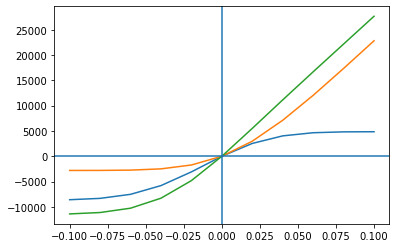

In [95]:
from FinAPI.normal_option_pricing import black_lognormal, black_lognormal_vol

# Option pricing

ticker = "SCX1C 4550 Index"
days_to_expire = 39
px_mid = 64.5
ivol_mid = 11.856
call_put = "Call"
strike = 4550
forward = 4538.12
df = 1

mode = "COB"

secs = active_securities
qtys=option_prem_collapsed[option_prem_collapsed['Security Id'].isin(secs)]

# Fields for BBG
bbg_static_fields = ['OPT_DAYS_EXPIRE',  'OPT_STRIKE_PX', 'OPT_PUT_CALL', 'FUT_VAL_PT']
price_field = 'PX_MID' if mode.upper()=='LIVE' else 'PX_SETTLE'
vol_field = 'IVOL_MID' if mode.upper()=='LIVE' else 'IVOL'
bbg_dynamic_fields = [price_field, 'OPT_UNDL_CALC_PX', vol_field]

# Fetch from Bloomberg
static_vals = LocalTerminal.get_reference_data(secs, bbg_static_fields)
dynamic_vals = LocalTerminal.get_reference_data(secs, bbg_dynamic_fields)

# black_lognormal(forward, strike, call_put, ivol_mid/100, days_to_expire/365, df=1)
# black_lognormal_vol(px_mid, forward, strike, call_put, days_to_expire / 365, df=1)

static_data = static_vals.as_map()
dynamic_data = dynamic_vals.as_map()

# PnL Profile
range_of_underlying_moves = np.linspace(-0.1, 0.1, num=11)
pv_profile = np.zeros(len(range_of_underlying_moves)) # PV  of the structure
indiv_profile = dict()  # inidividual Pnl profile (pv - current price)
mid_price = 0
for security in secs:
    qty = np.array(option_prem_collapsed.loc[option_prem_collapsed['Security Id']==security, 'total_exposure'])[0]
    mid = dynamic_data[security][price_field]  # Price in points
    mid_price = mid_price + qty * mid          # price in points of the structure
    # print(security, mid, qty, mid_price)
    
    forward = dynamic_data[security]['OPT_UNDL_CALC_PX']
    strike = static_data[security]['OPT_STRIKE_PX']
    call_put = static_data[security]['OPT_PUT_CALL']
    days_to_expire = static_data[security]['OPT_DAYS_EXPIRE']
    ivol = dynamic_data[security][vol_field]
    ivol_calc = black_lognormal_vol(mid, forward, strike, call_put, days_to_expire / 365, df=1)
    # print(ivol, ivol_calc)
    df=1
    iprofile = np.zeros(len(range_of_underlying_moves))
    for i, m in enumerate(range_of_underlying_moves):
        f = (1 + m) * forward
        if days_to_expire == 0:
            fl = 1 if call_put=='C' else -1
            pv = (1 - fl)/2 * (strike - f) + max(f - strike, 0)
        else:
            pv = black_lognormal(f, strike, call_put, ivol_calc, days_to_expire/365, df=df)
        pv_profile[i] = pv_profile[i] + qty * pv
        iprofile[i] = pv * qty - qty * mid
    indiv_profile[security] = pd.Series(iprofile, index=range_of_underlying_moves)
pv_profile = pd.Series(pv_profile, index=range_of_underlying_moves) - mid_price
indiv_profile = pd.DataFrame(indiv_profile)

# Delta Profile

# Theta decay

# Skew Snap

# IVOL TS

# Skew TS
# print(indiv_profile)
plt.plot(indiv_profile['SCX1C 4640 Index'] + indiv_profile['SCX1C 4550 Index'])
plt.plot(indiv_profile['SCX1C 4630 Index'])
plt.plot(pv_profile)
plt.axhline(0)
plt.axvline(0)

## EquityOption Object

In [60]:
objEquityTrade = EquityFutureOptionTrade(trade_name, working_df)

# Get the active securities in the trade name
active_securities = objEquityTrade.active_securities()
print(active_securities)

# Compute PnL for the active securities
objEquityTrade.compute_pnl_for_active_secs()

['SCX1C 4520 Index' 'SCV1C 4550 Index']


TypeError: can only join an iterable

## View Model

In [34]:
# View Model

trader_df =objPortfolio.get_trades_by_trader(objPortfolio.raw_data, 'troy')
trade_df = objPortfolio.create_position_pivot(trader_df)
trader_names = objPortfolio.trader_names(objPortfolio.raw_data)
asset_classes = objPortfolio.asset_classes(objPortfolio.raw_data)

def make_dropdown(dropdown_id, dropdown_label, dropdown_options, dropdown_value, multi=True, searchable=True, clearable=False, margin_left='5px', margin_right='5px', 
                    label_width=3):
    dd = dbc.Row(children=[
                            dbc.Col(html.Span(dropdown_label, style={'font-weight': 'bold'}), width=label_width, align="center"), 
                                    dbc.Col(dcc.Dropdown(id=dropdown_id, 
                                    options=dropdown_options, 
                                    value=dropdown_value, 
                                    multi=multi, searchable=searchable, clearable=clearable), align="center")
                          ], 
                 no_gutters=True, 
                 justify="end", 
                 style={'margin-left': margin_left, 'margin-right': margin_right})
    return dd



# View Components

positions_table = dash_table.DataTable(
    id='trade_table',
    columns=[{"name": i, "id": i} for i in trade_df.columns],
    data=trade_df.to_dict('records'),
    filter_action='native',
    style_cell={'textAlign': 'center', 'maxWidth': '100px'},
    style_header={
        'backgroundColor': 'gray',
        'fontWeight': 'bold', 
        'textAlign': 'center'
    },
    style_data={
        'whiteSpace': 'normal',
        'height': 'auto',
    },
    style_data_conditional=[
        {
            'if': {
                'filter_query': '{Trade Name} != ""',
            },
            'borderTop': '2px rgb(100, 100, 100) solid',
        },
        {
            'if': {
                'filter_query': '{MCMM} < 0',
                'column_id': 'MCMM'
            },
            'color': 'tomato',
            'fontWeight': 'bold'
        },
        {
            'if': {
                'filter_query': '{MassPRIM} < 0',
                'column_id': 'MassPRIM'
            },
            'color': 'tomato',
            'fontWeight': 'bold'
        },
        {
            'if': {
                'filter_query': '{PSAMF} < 0',
                'column_id': 'PSAMF'
            },
            'color': 'tomato',
            'fontWeight': 'bold'
        },
        {
            'if': {
                'filter_query': '{RVMaster} < 0',
                'column_id': 'RVMaster'
            },
            'color': 'tomato',
            'fontWeight': 'bold'
        },
        {
            'if': {
                'filter_query': '{UCITS} < 0',
                'column_id': 'UCITS'
            },
            'color': 'tomato',
            'fontWeight': 'bold'
        },
        {
            'if': {
                'filter_query': '{Total} < 0',
                'column_id': 'Total'
            },
            'color': 'tomato',
            'fontWeight': 'bold'
        },
        {
            'if': {'column_id': 'Trade Name'},
            'textAlign': 'left',
            'maxWidth': '150px'
        },
        {
            'if': {'column_id': 'Security Id'},
            'textAlign': 'left',
            'maxWidth': '150px'
        }
    ]
    )


trader_dropdown = make_dropdown('trade_name_filter', 'Select a Trader', [{'label':tname, 'value':tname.upper()} for tname in trader_names], 'troy',
                                 multi=False, searchable=True, label_width=2)

asset_class_dropdown = make_dropdown('asset_class_filter', 'Select a Asset Class', [{'label': 'All', 'value':'ALL'}] + [{'label': aname, 'value':aname.upper()} for aname in asset_classes],
                                    'ALL', multi=True, searchable=True, label_width=2)


table_filters = dbc.Checklist(
    id='trade_table_checklist',
    options=[
        {'label': 'Remove Closed Trades', 'value': 'NoClosed'},
        {'label': 'Remove Matured ISINS', 'value': 'NoExpired'},
        {'label': 'Show Only Option Trades', 'value': 'OnlyOptions'}
    ],
    value=['NoClosed', 'NoExpired'],
    labelStyle={'display': 'inline-block'},
    inline=True,
    style={'margin-left': '7px'}
)


selector_row1 = dbc.Row(children=[dbc.Col(children=[trader_dropdown], width=5), dbc.Col(children=[asset_class_dropdown], width=6), dbc.Col(width=1)])
selector_row2 = dbc.Row(children=[dbc.Col([table_filters], width=9), dbc.Col(width=3)], style={'margin-top': '15px'})

filter_toolbar = dbc.Container(children=[selector_row1, selector_row2], fluid=True)

# Date Select
def make_date_picker(app, id_suffix, min_date_allowed=None, max_date_allowed=None, initial_visible_month=None, end_date=None):
    option = ['eq', 'before', 'after', 'between']
    dd_id = 'date_picker_operator_' + id_suffix
    rng_picker_id = 'date_range_picker_' + id_suffix
    sngl_picker_id = 'date_single_picker_' + id_suffix
    min_date_allowed = date(2019, 1, 1) if min_date_allowed is None else min_date_allowed
    max_date_allowed = date.today() if max_date_allowed is None else max_date_allowed
    initial_visible_month = date.today() if initial_visible_month is None else initial_visible_month
    end_date = date.today() if end_date is None else end_date

    daterangepick = dbc.Row(children= [
                                dbc.Col([dcc.Dropdown(id=dd_id, 
                                        options=[{'label': op, 'value': op} for op in option], 
                                        value='before', 
                                        multi=False, searchable=False, clearable=False, style={'height': '48px'})], width=1),
                                dbc.Col(children=[dcc.DatePickerRange(
                                                                        id=rng_picker_id,
                                                                        min_date_allowed=min_date_allowed,
                                                                        max_date_allowed=max_date_allowed,
                                                                        initial_visible_month=initial_visible_month,
                                                                        end_date=end_date,
                                                                        display_format='DD-MMM-YY',
                                                                        style={'display': 'none'}
                                                                    ),
                                                    dcc.DatePickerSingle(
                                                        id=sngl_picker_id,
                                                        min_date_allowed=min_date_allowed,
                                                        max_date_allowed=max_date_allowed,
                                                        initial_visible_month=initial_visible_month,
                                                        date=end_date,
                                                        display_format='DD-MMM-YY',
                                                        style={'display': 'block'}
                                                    ),
                                                ], 
                                        width=11)
                            ], no_gutters=True)

    @app.callback([Output('trade_pivot_date_range_picker', 'style'), Output('trade_pivot_date_single_picker', 'style')], Input('date_picker_operator_trade_pivot', 'value'))
    def toggle_date_input_visibility(val):
        if val=='between':
            return {'display': 'block'}, {'display': 'none'}
        else:
            return {'display': 'none'}, {'display': 'block'}
    
    return 



In [35]:
# Build App and Call Backs

app = JupyterDash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])



In [36]:
# app.layout = dbc.Container([
#     html.H1("Portfolio Dashboard (Data: %s)" % today.strftime('%d-%m-%Y')),
#     bootstrap_row,
#     positions_table
# ], style={'margin-left': '5px',  'margin-right':'5px'})

app.layout = daterangepick
# Run app and display result inline in the notebook
app.run_server(mode='external', port=8051)


Dash app running on http://127.0.0.1:8051/
